In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
from dataset import StoneDataset
import seaborn as sns
import random
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import pandas as pd

In [5]:
# pip install seaborn

Text(0.5, 1.0, 'Class Distribution in Training Set')

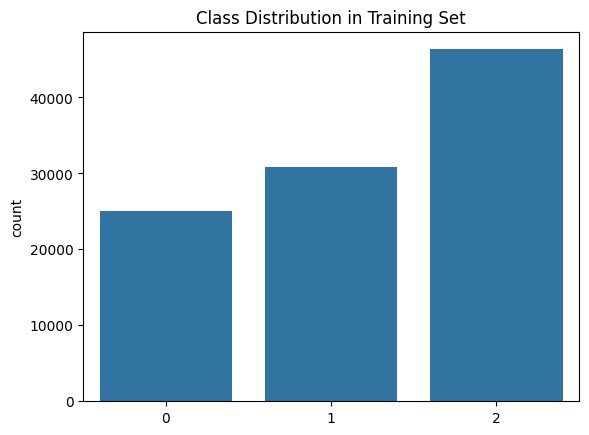

In [6]:
train_data = StoneDataset(root="./dataset/train_val", split="train", transforms=transforms.ToTensor())

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

labels = train_data.labels
sns.countplot(x=labels)
plt.title("Class Distribution in Training Set")

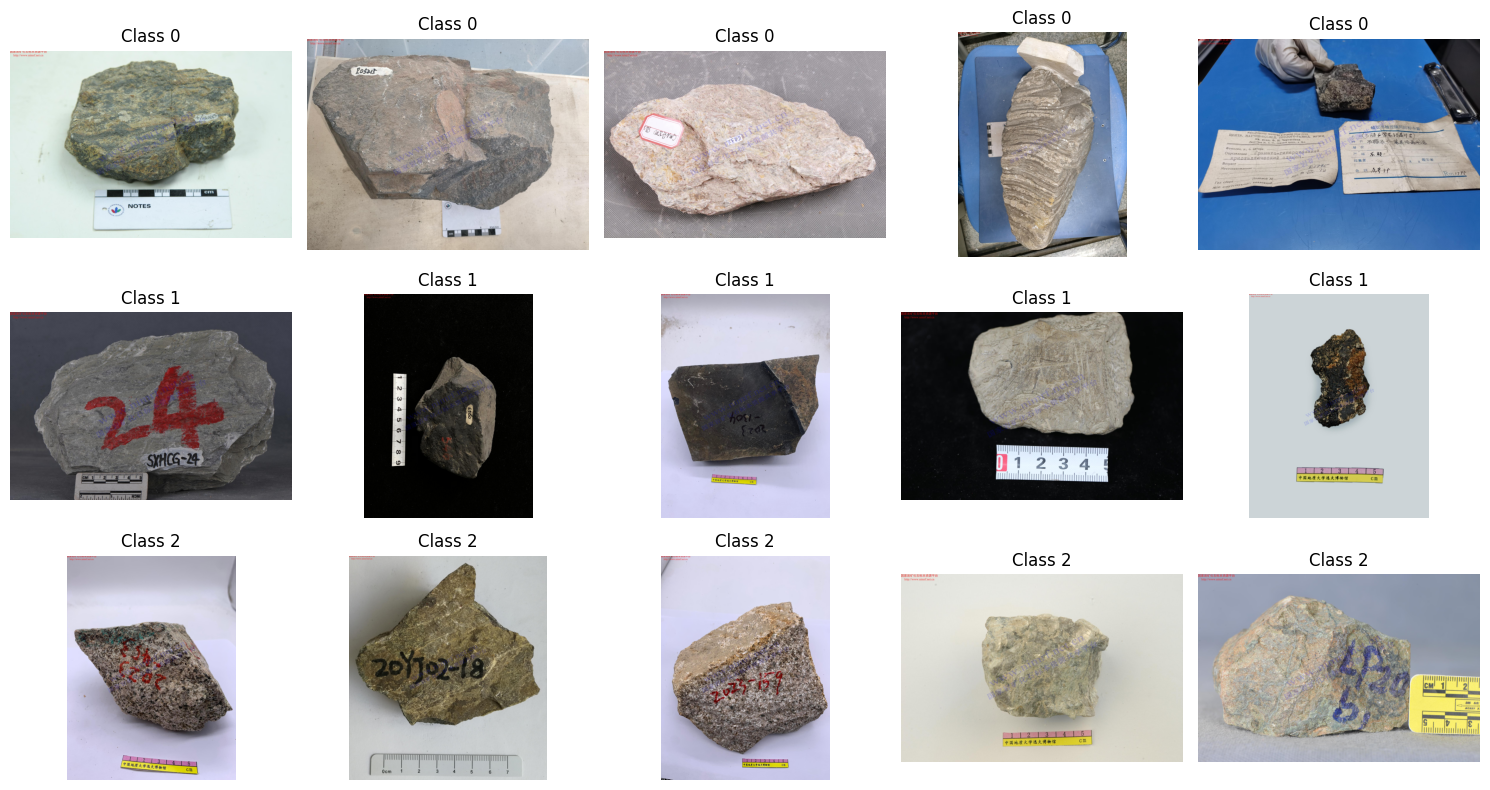

In [7]:
class_indices = {0: [], 1: [], 2: []}
for idx, label in enumerate(train_data.labels):
    class_indices[label].append(idx)

num_samples_per_class = 5
selected_indices = {}
for cls in class_indices:
    if len(class_indices[cls]) >= num_samples_per_class:
        selected_indices[cls] = random.sample(class_indices[cls], num_samples_per_class)
    else:
        selected_indices[cls] = class_indices[cls]

# 直接转换张量为 PIL 图像（无需反归一化）
def tensor_to_pil(tensor):
    return transforms.ToPILImage()(tensor.cpu().clone().squeeze(0))

# 显示图像
fig, axes = plt.subplots(len(selected_indices), num_samples_per_class, figsize=(15, 8))
for cls_idx, cls in enumerate(selected_indices):
    for i, idx in enumerate(selected_indices[cls]):
        img, label = train_data[idx]
        img_pil = tensor_to_pil(img)  # 直接转换
        ax = axes[cls_idx, i]
        ax.imshow(img_pil)
        ax.axis('off')
        ax.set_title(f'Class {cls}')
plt.tight_layout()
plt.show()

In [8]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 验证/测试集预处理
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 创建DataLoader
batch_size = 128
train_loader = DataLoader(
    StoneDataset(root="./dataset/train_val", split="train", transforms=train_transform),
    batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    StoneDataset(root="./dataset/train_val", split="val", transforms=val_transform),
    batch_size=batch_size, shuffle=False, num_workers=4
)

In [9]:
def build_resnet18(num_classes=3, pretrained=True):
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    # 替换最后一层全连接层
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_labels = train_data.labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    model = model.to(device)
    best_acc = 0.0
    train_losses, val_losses, val_f1,val_accs= [], [], [],[]
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # 验证阶段
        val_loss, val_acc, val_f1_score = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_f1.append(val_f1_score)
        val_accs.append(val_acc)
        
        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%} | Val F1: {val_f1_score:.4f}')  # 新增 F1
    
    history = {'train_loss': train_losses, 'val_loss': val_losses, 'val_acc': val_accs, 'val_f1': val_f1}
    return model, history

In [12]:
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / len(data_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1

In [13]:
model = build_resnet18(num_classes=3,pretrained=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 15.2MB/s]


In [14]:
# 训练模型
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20
)

Epoch 1/20 | Train Loss: 0.8716 | Val Loss: 0.8386 | Val Acc: 59.57% | Val F1: 0.5764
Epoch 2/20 | Train Loss: 0.8096 | Val Loss: 0.7596 | Val Acc: 65.48% | Val F1: 0.6501
Epoch 3/20 | Train Loss: 0.7811 | Val Loss: 0.7785 | Val Acc: 64.21% | Val F1: 0.6274
Epoch 4/20 | Train Loss: 0.7617 | Val Loss: 0.7342 | Val Acc: 67.23% | Val F1: 0.6683
Epoch 5/20 | Train Loss: 0.7424 | Val Loss: 0.7544 | Val Acc: 67.07% | Val F1: 0.6657
Epoch 6/20 | Train Loss: 0.7266 | Val Loss: 0.7045 | Val Acc: 68.73% | Val F1: 0.6836
Epoch 7/20 | Train Loss: 0.7135 | Val Loss: 0.7122 | Val Acc: 68.89% | Val F1: 0.6855
Epoch 8/20 | Train Loss: 0.7021 | Val Loss: 0.6840 | Val Acc: 70.07% | Val F1: 0.6987
Epoch 9/20 | Train Loss: 0.6885 | Val Loss: 0.7152 | Val Acc: 69.13% | Val F1: 0.6896
Epoch 10/20 | Train Loss: 0.6792 | Val Loss: 0.6792 | Val Acc: 70.33% | Val F1: 0.7042
Epoch 11/20 | Train Loss: 0.6635 | Val Loss: 0.6555 | Val Acc: 71.65% | Val F1: 0.7172
Epoch 12/20 | Train Loss: 0.6575 | Val Loss: 0.6493 

In [15]:
def predict(model, test_loader):
    model.eval()
    filenames = []
    predictions = []
    
    with torch.no_grad():
        for images, paths in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            filenames.extend(list(paths))
            predictions.extend(preds.cpu().numpy())
    
    return filenames, predictions

# 测试集加载
test_loader = DataLoader(
    StoneDataset(root="./dataset/test", split="test", transforms=val_transform),
    batch_size=batch_size, shuffle=False
)

# 生成预测结果
filenames, preds = predict(model, test_loader)

In [14]:
# df = pd.DataFrame({"filename": filenames, "label": preds})
# df.to_csv("submission1.csv", index=False)

In [16]:
df = pd.DataFrame({"filename": filenames, "label": preds})
df.to_csv("submission1new.csv", index=False)

In [9]:
# import matplotlib.pyplot as plt
# def plot_training_log():
#     epochs = list(range(1, 51))  # 共50个epoch

#     train_loss = [
#         0.8718, 0.8126, 0.7835, 0.7637, 0.7441, 0.7304, 0.7174, 0.7027, 0.6926, 0.6772,
#         0.6670, 0.6582, 0.6436, 0.6346, 0.6253, 0.6170, 0.6075, 0.5981, 0.5916, 0.5829,
#         0.5739, 0.5616, 0.5529, 0.5485, 0.5412, 0.5318, 0.5206, 0.5131, 0.5091, 0.5001,
#         0.4957, 0.4847, 0.4815, 0.4705, 0.4675, 0.4585, 0.4532, 0.4485, 0.4402, 0.4355,
#         0.4308, 0.4241, 0.4146, 0.4080, 0.4056, 0.4013, 0.3946, 0.3881, 0.3847, 0.3825
#     ]
#     val_loss = [
#         0.8245, 0.8321, 0.7760, 0.7535, 0.7497, 0.7509, 0.6919, 0.6860, 0.6789, 0.6628,
#         0.6713, 0.6436, 0.6541, 0.6331, 0.6438, 0.6616, 0.6725, 0.6728, 0.6271, 0.6323,
#         0.6370, 0.6767, 0.6547, 0.6518, 0.6784, 0.6501, 0.6529, 0.6328, 0.6615, 0.6713,
#         0.6723, 0.6617, 0.6910, 0.6864, 0.6716, 0.7151, 0.7101, 0.6831, 0.7460, 0.6923,
#         0.7049, 0.7188, 0.7491, 0.7499, 0.7660, 0.7915, 0.7792, 0.8056, 0.7968, 0.7500
#     ]

#     plt.figure(figsize=(12, 7))

#     plt.plot(epochs, train_loss, label='Train Loss', color='blue', linewidth=2)
#     plt.plot(epochs, val_loss, label='Val Loss', color='orange', linewidth=2)
#     plt.title('Resnet-18 Model Training History')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


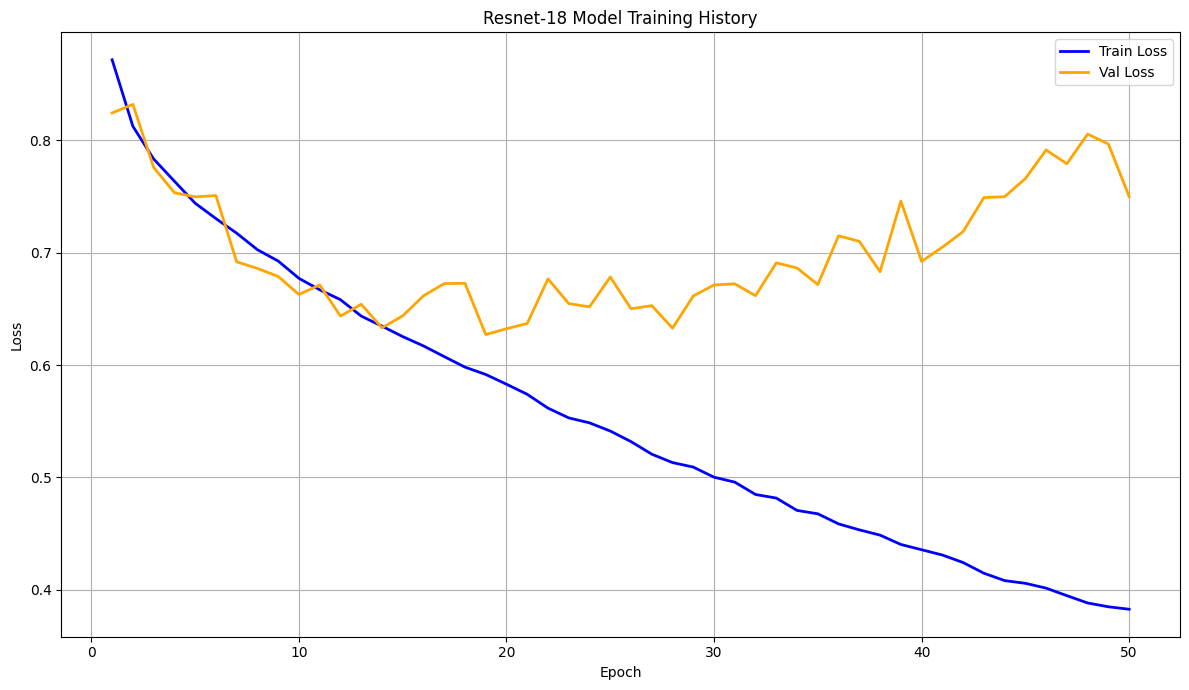

In [10]:
plot_training_log()